In [3]:
  # packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

HANDSHAKE_LENGTH = 100

In [4]:
# Generates a signal of 0 and 1 that is num_cycles long
# @param num_cycle the length of the signal
# @return a tuple of the signals and schedule, schedule says how long a bit at the corresponding point in signals is active
# Example: a return of [1,1,0], [2,2,1] would indicate that the first bit (1) in signals is active for two cycles and the second bit (0) is active for one
def generate_signals(num_cycle, rate_max=1):
  signals = np.array([])

  # for simplicity now
  schedule = np.array([])

  for _ in range(HANDSHAKE_LENGTH):
    signals = np.append(signals, 1)
    schedule = np.append(schedule, HANDSHAKE_LENGTH)

  for _ in range(HANDSHAKE_LENGTH):
    signals = np.append(signals, 0)
    schedule = np.append(schedule, HANDSHAKE_LENGTH)


  i = 0
  while i < num_cycle:
    # 0 or 1, depending on what the sender is sending
    curr_bit = np.random.randint(low=0,high=2)
    # rate is how long a certain bit will be active for, before going to the next one
    rate = np.random.randint(low=rate_max,high=rate_max+1) # not include 21, only 1 to 20

    # if chosen length takes you past the total length, turn it down so there is not any extra
    # if not, keep same as chosen
    if i + rate > num_cycle:
      repeat_time = num_cycle - i
    else:
      repeat_time = rate

    # for the amount of repeat_time (rate if it is able, until the end if not), append corresponding schedule and rate values
    for _ in range(repeat_time):
      signals = np.append(signals, curr_bit)
      schedule = np.append(schedule, rate)
      i = i + 1
  return signals, schedule


In [5]:
# Assume we know the number of jammers plus only 1 sender
NUMBER_TO_KNOW_TRUE = 1

# Or maybe we can infer the number of jammers based on the amplitude of received signals?
def approx_signals_min_max(received_signals, schedule, num_jammer=1):
  signals = np.zeros(shape=received_signals.shape,dtype=int)
  
  # based on schedule
  
  # where to jump to after processing current bit
  next_idx = int(schedule[1]) + 2*HANDSHAKE_LENGTH

  i = 2*HANDSHAKE_LENGTH
  while i < len(received_signals):
    if i >= next_idx:
      next_idx = int(next_idx + int(schedule[i]))
      window_size = schedule[i]

      # handle the edge case
      if next_idx > len(received_signals):
        next_idx = len(received_signals)
        window_size = len(received_signals) - i

    # two cases for one constant signal
    if np.any(received_signals[i:next_idx] == 0):
      # jammer 0 + sender 0 = 0
      signals[i:next_idx] = 0
      i = next_idx

    # num of jammer + 1 sender
    elif np.count_nonzero(received_signals[i:next_idx] >= num_jammer + 1) >= NUMBER_TO_KNOW_TRUE:
      # jammer 1 + sender 1 = 2
      signals[i:next_idx] = 1
      i = next_idx

    else:
      if random.random() > 0.5:
        # jammer might send 1 since higher average
        signals[i:next_idx] = 1
        i = next_idx
      else:
        # jammer might send 0 since lower average
        signals[i:next_idx] = 0
        i = next_idx
  return signals

In [6]:
def approx_signals_sliding_window(received_signals, schedule, num_jammer=1, window_slide=20):
    signals = np.zeros(shape=received_signals.shape,dtype=int)
    signals[HANDSHAKE_LENGTH:2*HANDSHAKE_LENGTH] = 1

    for i, _ in enumerate(received_signals):
        if i < 2*HANDSHAKE_LENGTH:
            continue
        window_idx = i-window_slide if i-window_slide >= 0 else 0
        avg_sig = sum(received_signals[window_idx:i])/(i+1)

        if avg_sig > (num_jammer+1)/2:
            signals[i] = 1
        else:
            signals[i] = 0


    return signals

In [7]:
def approx_signals_baseline(received_signals, schedule, num_jammer=1):
    signals = np.zeros(shape=received_signals.shape,dtype=int)
    signals[HANDSHAKE_LENGTH:2*HANDSHAKE_LENGTH] = 1
    for i, signal in enumerate(received_signals[2*HANDSHAKE_LENGTH:]):
        if signal == num_jammer+1:
            signals[i] = -1
        else:
            signals[i] = signal
    return signals

In [8]:
def add_noise(l, p_val=0.0):
    for i, data in enumerate(l):
        cur_rand = random.random()
        if cur_rand < p_val:
            l[i] += 1
        elif cur_rand < p_val*2:
            l[i] -= 1
    
    return l

In [9]:
# runs for a variable jammer maximum rate
# @param num_runs the number of rns you want to take the average over
# @return the dataframe containing Time Length, Accuracy, and Jammer Max Rate arrays
def run_variable_jammer_rate(num_runs, accuracy_runs=10, noise_probability=0.0): 
  # init data frame
  df = pd.DataFrame({"Time Length":[], "Min Max Accuracy":[], "Window Accuracy":[], "Baseline Accuracy":[], "Jammer Avg Rate":[]})
  all_send = []
  all_jam = []
  time_interval = 10**3
  # get sender signals with set max rate = 21
  SENDER_RATE = 10
  for i in range(num_runs):
    cur_min_max_accuracy = []
    cur_baseline = []
    cur_window = []
    for _ in range(accuracy_runs):

      # get the jammer signals with a certian max rate, determined by current innteration
      sender_signals, schedule = generate_signals(time_interval, SENDER_RATE)
      jammer_signals, _ = generate_signals(time_interval, i)

      # # get sender signals with set max rate = 21
      # sender_signals, schedule = generate_signals(time_interval, 20)

      # summing the two signals will give the recieved signals
      received_signals = jammer_signals + sender_signals

      received_signals = add_noise(received_signals, p_val=noise_probability)

      # process the recieve through the algorithim
      processed_signals_min_max = approx_signals_min_max(received_signals, schedule, num_jammer=1)
      processed_signals_window = approx_signals_sliding_window(received_signals, schedule, num_jammer=1)
      processed_signals_baseline = approx_signals_baseline(received_signals, schedule, num_jammer=1)

      # determine the accuracy by summing up all the equals over the processed and sent, then taking eprcent
      min_max_accuracy = np.sum(np.equal(sender_signals, processed_signals_min_max)) * 100 / time_interval
      window_accuracy = np.sum(np.equal(sender_signals, processed_signals_window)) * 100 / time_interval
      baseline_accuracy = np.sum(np.equal(sender_signals, processed_signals_baseline)) * 100 / time_interval

      cur_min_max_accuracy.append(min_max_accuracy)
      cur_window.append(window_accuracy)
      cur_baseline.append(baseline_accuracy)
      
    # add the current run to the data frame
    df.loc[len(df)] = {"Time Length":time_interval, "Min Max Accuracy":sum(cur_min_max_accuracy) / len(cur_min_max_accuracy), "Window Accuracy":sum(cur_window) / len(cur_window), "Baseline Accuracy":sum(cur_baseline)/len(cur_baseline), "Jammer Avg Rate":i/SENDER_RATE}

    all_send.append(sender_signals)
    all_jam.append(jammer_signals)

  # add average statistics
  df.loc[len(df)] = {"Time Length": df["Time Length"].mean(), "Min Max Accuracy": df["Min Max Accuracy"].mean(), "Window Accuracy": df["Window Accuracy"].mean(), "Baseline Accuracy": df["Baseline Accuracy"].mean(), "Jammer Avg Rate": i/SENDER_RATE}
  
  accu = df["Min Max Accuracy"]
  stats = {'mean': (accu.mean()), "median": accu.median(), "min": (accu.argmin(), accu.min()), "max": (accu.argmax(), accu.max())}
  return df, stats, all_send, all_jam


In [10]:
df, stats, send_sig, jam_sig = run_variable_jammer_rate(190)

plt.plot(df["Jammer Avg Rate"][:-1], df["Min Max Accuracy"][:-1], label="Min Max Accuracy")
plt.plot(df["Jammer Avg Rate"][:-1], df["Window Accuracy"][:-1], label="Window Accuracy")
plt.plot(df["Jammer Avg Rate"][:-1], df["Baseline Accuracy"][:-1], label="Baseline Accuracy")
plt.legend()
plt.title("Accuracy of Different methods")
plt.xlabel("Ratio of Jammer Average Bit Length to Sender Average Bit Length")
plt.ylabel("Accuracy (%)")
plt.show()

df.to_csv('variable_jammer_rate_based_on_algorithim.csv')
print(stats)

KeyboardInterrupt: 

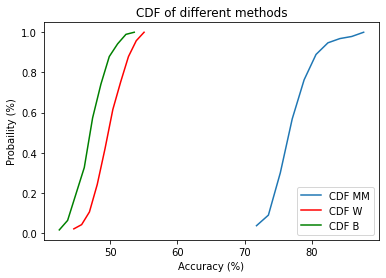

In [ ]:
df, stats, send_sig, jam_sig = run_variable_jammer_rate(190)
  
count_mm, bins_count_mm = np.histogram(df["Min Max Accuracy"][:-1], bins=10) 
pdf_mm = count_mm / sum(count_mm) 
cdf_mm = np.cumsum(pdf_mm) 

count_w, bins_count_w = np.histogram(df["Window Accuracy"][:-1], bins=10) 
pdf_w = count_w / sum(count_w) 
cdf_w = np.cumsum(pdf_w) 

count_b, bins_count_b = np.histogram(df["Baseline Accuracy"][:-1], bins=10) 
pdf_b = count_b / sum(count_b) 
cdf_b = np.cumsum(pdf_b) 
  
plt.plot(bins_count_mm[1:], cdf_mm, label="CDF MM")

plt.plot(bins_count_w[1:], cdf_w, label="CDF W", color="red")

plt.plot(bins_count_b[1:], cdf_b, label="CDF B", color="green")

plt.title("CDF of different methods")
plt.xlabel("Accuracy (%)")
plt.ylabel("Probaility (%)")

plt.legend()
plt.show()

In [ ]:
# chart for window parameter
# runs for a variable jammer maximum rate
# @param num_runs the number of rns you want to take the average over
# @return the dataframe containing Time Length, Accuracy, and Jammer Max Rate arrays
def run_window_checker(num_runs): 
  # init data frame
  df = pd.DataFrame({"Time Length":[], "Window Accuracy":[], "Window Size":[]})
  time_interval = 10**3
  # get sender signals with set max rate = 21

  for i in range(num_runs):
    cur_window = 0
    nums = 0
    for _ in range(10):
      sender_signals, schedule = generate_signals(time_interval, 15)
      jammer_signals, _ = generate_signals(time_interval, 40)

      # summing the two signals will give the recieved signals
      received_signals = jammer_signals + sender_signals

      processed_signals_window = approx_signals_sliding_window(received_signals, schedule, num_jammer=1, window_slide=i)

      window_accuracy = np.sum(np.equal(sender_signals, processed_signals_window)) * 100 / time_interval

      cur_window += window_accuracy
      nums += 1

    # add the current run to the data frame
    df.loc[len(df)] = {"Time Length":time_interval, "Window Accuracy": cur_window/nums, "Window Size": i}

  # add average statistics
  df.loc[len(df)] = {"Time Length": df["Time Length"].mean(), "Window Accuracy": df["Window Accuracy"].mean(), "Window Size": i}
  
  accu = df["Window Accuracy"]
  stats = {'mean': (accu.mean()), "median": accu.median(), "min": (accu.argmin(), accu.min()), "max": (accu.argmax(), accu.max())}
  return df, stats

In [ ]:
df, stats = run_window_checker(1000)

df.to_csv("checking_window_size.csv")

plt.plot(df["Window Size"][:-1], df["Window Accuracy"][:-1])
plt.title("Accuracy based on sliding Window Size")
plt.xlabel("Size of the 'Window'")
plt.ylabel("Accuracy (%)")
plt.show()

stats

KeyboardInterrupt: 

In [ ]:
# runs for a variable jammer rate when teh jammer rate and the sender rate are verhy close together
# @param num_runs the number of rns you want to take the average over
# @return the dataframe containing Time Length, Accuracy, and Jammer Max Rate arrays
def jammer_sender_very_close():
  # init data frame
  df = pd.DataFrame({"Time Length":[], "Min Max Accuracy":[], "Jammer Avg Rate":[]})
  time_interval = 10**3
  # get sender signals with set max rate = 21
  SENDER_RATE = 100
  sender_signals, schedule = generate_signals(time_interval, SENDER_RATE)
  for i in range(SENDER_RATE-10, SENDER_RATE+10):
    cur_min_max_accuracy = []
    for _ in range(1000):

      # get the jammer signals with a certian max rate, determined by current innteration
      jammer_signals, _ = generate_signals(time_interval, i)

      # # get sender signals with set max rate = 21
      # sender_signals, schedule = generate_signals(time_interval, 20)

      # summing the two signals will give the recieved signals
      received_signals = jammer_signals + sender_signals

      # process the recieve through the algorithim
      processed_signals_min_max = approx_signals_min_max(received_signals, schedule, num_jammer=1)

      # determine the accuracy by summing up all the equals over the processed and sent, then taking eprcent
      min_max_accuracy = np.sum(np.equal(sender_signals, processed_signals_min_max)) * 100 / time_interval

      cur_min_max_accuracy.append(min_max_accuracy)

    # add the current run to the data frame
    df.loc[len(df)] = {"Time Length":time_interval, "Min Max Accuracy":sum(cur_min_max_accuracy) / len(cur_min_max_accuracy), "Jammer Avg Rate":i/SENDER_RATE}

  # add average statistics
  df.loc[len(df)] = {"Time Length": df["Time Length"].mean(), "Min Max Accuracy": df["Min Max Accuracy"].mean(), "Jammer Avg Rate": i/SENDER_RATE}
  
  accu = df["Min Max Accuracy"]
  stats = {'mean': (accu.mean()), "median": accu.median(), "min": (accu.argmin(), accu.min()), "max": (accu.argmax(), accu.max())}
  return df, stats


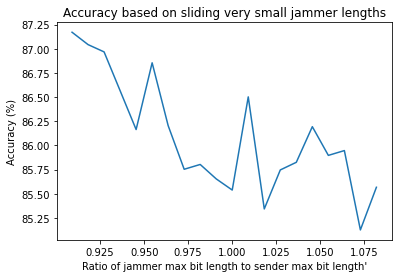

{'mean': 86.09327500000009,
 'median': 85.94670000000019,
 'min': (18, 85.12630000000006),
 'max': (0, 87.17020000000011)}

In [ ]:
df, stats = jammer_sender_very_close()

plt.plot(df["Jammer Avg Rate"][:-1], df["Min Max Accuracy"][:-1])
plt.title("Accuracy based on sliding very small jammer lengths")
plt.xlabel("Ratio of jammer max bit length to sender max bit length'")
plt.ylabel("Accuracy (%)")
plt.show()

stats

New algorithim:

Use Min Max
